# Implied Volatility and Volatiity Smile

In [17]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import newton
from scipy.stats import norm

from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

import numpy
from numpy.random import randn
from scipy import array, newaxis

In [18]:
# Get stock data

nifty_data = pd.read_csv("data/data.csv")
nifty_data['IV'] = 0
print(nifty_data.head())

  Symbol        Date     Expiry Option Type  Strike Price    Open    High  \
0  NIFTY  10-11-2017  28-Dec-17          CE         10100  342.00  384.55   
1  NIFTY  10-11-2017  28-Dec-17          CE         10200  274.05  308.15   
2  NIFTY  10-11-2017  28-Dec-17          CE         10300  213.15  239.05   
3  NIFTY  10-11-2017  28-Dec-17          CE         10400  156.10  177.75   
4  NIFTY  10-11-2017  28-Dec-17          CE         10500  117.45  128.45   

      Low   Close     LTP  Settle Price  No. of contracts  Turnover in Lacs  \
0  319.95  346.65  357.25        346.65               369           2891.94   
1  246.00  280.10  288.00        280.10               814           6395.29   
2  184.95  214.45  220.00        214.45              2489          19614.17   
3  133.40  153.65  161.45        153.65              2648          20963.42   
4   92.60  112.20  117.70        112.20              8500          67640.94   

   Premium Turnover in Lacs  Open Int  Change in OI  Underlyin

## Black and Scholes 

In [19]:
def black_shcoles_call(S, K, T, r, sigma):

    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    call = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))

    return call

def min_func(sigma, S, K, T, r, C):
    if sigma < 0:
        return np.inf
    bs_val = black_shcoles_call(S, K, T, r, sigma)
    return abs(bs_val - C)

## Implied Volatility using Newtons method

In [20]:
def implied_sig(S, K, r, T, C):
    return newton(
        min_func,
        0.02,
        args = (
            S,
            K,
            T,
            r,
            C
        ),
        maxiter=10000,
    )


In [21]:
# Find the actual implied volatilities

implied_vols = {}
for date in list(set(nifty_data['Date'])):
    implied_vols[date] = []


# Computing implied volatilities
for row in range(0,len(nifty_data)):
    underlyingPrice = nifty_data.iloc[row]['Underlying Value']
    strikePrice = nifty_data.iloc[row]['Strike Price']
    interestRate = 0
    daysToExpiration = nifty_data.iloc[row]['Time to Expiry']
    callPrice = nifty_data.iloc[row]['LTP']

    if float(callPrice) == 0.0:
        continue

    result = implied_sig(
        underlyingPrice,
        strikePrice,
        interestRate,
        daysToExpiration,
        callPrice
    )
    implied_vols[nifty_data.iloc[row]['Date']].append({
        "strikePrice" : strikePrice,
        "impliedVol" : result,
        "daysToExpiration" : daysToExpiration
    })


## Volatility Smile

In [22]:
# Plot smiles helper functions

def plot_2D():
    dates = []
    for date, vols in list(implied_vols.items())[4:]:
        x = [vol["strikePrice"] for vol in vols]
        y = [vol["impliedVol"] for vol in vols]
        plt.plot(x, y)
        plt.title("Volatility Smile\nImplied Volatility as a function of Strike Price K", fontsize=18)
        plt.ylabel('Implied Volatility', fontsize=15)
        plt.xlabel('K Strike Price [USD]', fontsize=15)
        dates.append(str(date) + ", T = " + str(vols[0]["daysToExpiration"]))
    plt.legend(dates, fontsize=14)
    plt.show()

def plot_3D():
    X, Y, Z = [], [], []
    for date, vols in implied_vols.items():
        X += [vol["strikePrice"] for vol in vols]
        Y += [vol["daysToExpiration"] for vol in vols]
        Z += [vol["impliedVol"] for vol in vols]

    """
    X, Y, Z = np.array(X),np.array(Y), np.array(Z)
    ax = plt.axes(projection='3d')
    ax.scatter3D(X, Y, Z)
    plt.show()
    """

    #ax.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(X, Y, Z, cmap=cm.jet, linewidth=0)
    fig.colorbar(surf)

    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(5))

    fig.tight_layout()

    plt.xlabel("K - Strike Price [USD] ", fontsize=15)
    plt.ylabel("T - Days to Expiration [Days] ", fontsize=15)
    #plt.zlabel("$/sigma$ - Implied Volatility ")
    plt.show()
    
def plot_stocks(stocks, name="Facebook"):
    days = list(range(1, len(stocks[0]) + 1))
    
    # plot all stocks
    for stock in stocks:
        plt.plot(days, stock)
        
    # output
    plt.title(name + " stock as a function of time")
    plt.xlabel("Time [Days]")
    plt.ylabel("Price [USD]")
    plt.legend(["Real"])
    plt.show()


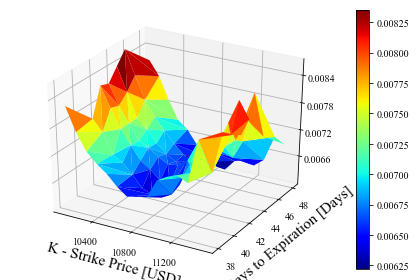

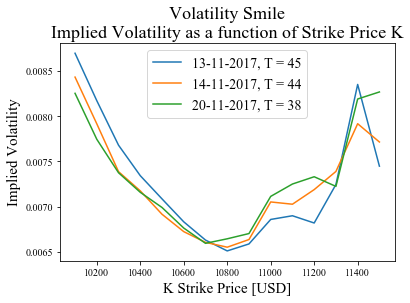

In [23]:
plot_3D()
plot_2D()

# Heston Model

In [24]:
# Helper functions

def normal_distrib(sigma=1, mean=0, count=1):
    return numpy.random.normal(mean, sigma, count)

def correlated_normal2(corr):
    numpy.random.normal(mean, sigma, count)
    xx = np.array([-0.51, 51.2])
    yy = np.array([0.33, 51.6])
    means = [xx.mean(), yy.mean()]  
    stds = [xx.std() / 3, yy.std() / 3]
    covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
            [stds[0]*stds[1]*corr,           stds[1]**2]] 

    m = np.random.multivariate_normal(means, covs, 1000).T
    scatter(m[0], m[1])

def correlated_normal(corr):
    w1 = np.random.normal(0, 1)
    w2 = corr*w1+np.sqrt(1-corr**2)*np.random.normal(0, 1)
    return w1, w2
    


## Heston Model explicit formula

In [25]:
def heston_model(S_0, length, mu, theta, k, zeta, corr):
    dt = 1

    S = [0] * length
    V = [0] * length
    
    S[0] = S_0
    V[0] = theta
    
    for i in range(1, length):
        # generate two noises with correlation p
        s_noise, v_noise = correlated_normal(corr)
        
        S[i] = S[i - 1] + mu * S[i - 1] * dt + np.sqrt(V[i - 1]) * S[i -1] * s_noise
        V[i] = V[i - 1] + k * (theta - V[i - 1]) + zeta * np.sqrt(V[i - 1]) * v_noise

    return S, V


def heston_model_old(option_type,S0,K,T,initial_var,long_term_var,rate_reversion,vol_of_vol,corr,r,num_reps,steps):
    """
    option_type:    'p' put option 'c' call option
    S0:              the spot price of underlying stock
    K:              the strike price
    T:              the maturity of options
    initial_var:    the initial value of variance
    long_term_var:  the long term average of price variance
    rate_reversion: the mean reversion rate for the variance
    vol_of_vol:     the volatility of volatility(the variance of the variance of stock price)
    corr:           the correlation between the standard normal random variables W1 and W2
    r:              the risk free rate
    reps:           the number of repeat for monte carlo simulation
    steps:          the number of steps in each simulation
    """
    delta_t = T/float(steps)
    payoff = 0
    for i in range(num_reps):
        vt = initial_var
        st = S0
        for j in range(steps):
            w1 = np.random.normal(0, 1)
            w2 = corr*w1+sqrt(1-corr**2)*np.random.normal(0, 1)
            vt = (sqrt(vt) + 0.5 * vol_of_vol * sqrt(delta_t) * w1)**2  \
                 - rate_reversion * (vt - long_term_var) * delta_t \
                 - 0.25 * vol_of_vol**2 * delta_t
            st = st * exp((r - 0.5*vt)*delta_t + sqrt(vt*delta_t) * w2)
        if option_type == 'c':
                payoff += max(st - K, 0)
        elif option_type == 'p':
                payoff += max(K - st, 0)

    return (payoff/float(num_reps)) * (exp(-r*T))


In [29]:
# Example for heston model parameters

long_term_var = 0.191762, 
rate_reversion = 0.000001, 
vol_of_vol = 0.215442, 
corr = -0.817388, 
initial_var = 0.198778


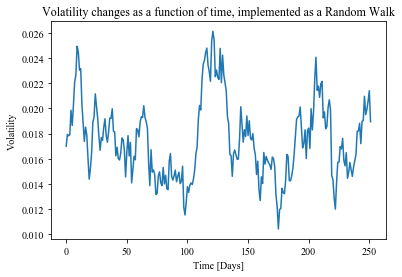

In [46]:
def plot_random_vol():
    stock_pred, volatility_pred = heston_model(
        102, 
        252, 
        0.000625570019147,
        0.017,
        0.1,
        0.01,
        0.5
    )

    plt.plot(list(range(252)), volatility_pred)
    plt.xlabel("Time [Days]")
    plt.ylabel("Volatility")
    plt.title("Volatility changes as a function of time, implemented as a Random Walk")
    plt.show()
    
plot_random_vol()




    

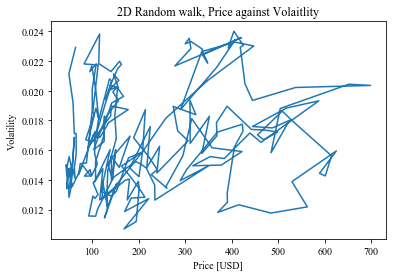

In [32]:
def plot_2D_random_walk():
    heston_pred, volatility_pred = heston_model(
        102, 
        252, 
        0.000625570019147,
        0.017,
        0.1,
        0.01,
        0.5
    )

    plt.plot(heston_pred, volatility_pred)
    plt.xlabel("Price [USD]")
    plt.ylabel("Volatility")
    plt.title("2D Random walk, Price against Volaitlity")
    plt.show()
    
plot_2D_random_walk()




    

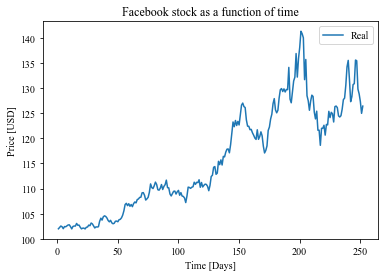

[ 102.          102.28726406  102.55008363  102.41397173  102.0197113
  102.44653155  102.40108653  102.58357244  102.76121797  102.78825385
  102.41839156  101.98539181  102.47184292  102.55290742  102.54323198
  103.06896061  102.70160283  102.7416942   102.30793732  101.99116351
  102.1220211   102.13531629  101.97623051  102.29941735  102.35679433
  102.73255804  102.61294125  103.15005392  102.97963298  102.59049265
  102.1665619   102.38182293  102.35288011  102.41757691  103.49443026
  104.10965538  103.73395319  104.38629357  104.57966699  104.46359893
  104.15563976  103.65199399  103.38750685  103.68859932  103.19233665
  102.99863454  103.09685881  103.5064182   103.53808195  103.40533729
  103.80930325  103.88205722  104.17548691  104.71703055  105.58214046
  106.82841809  107.07137069  106.60720224  106.99474853  106.48083506
  106.8343067   106.40806186  107.01161596  107.33842422  107.15956093
  107.81726274  107.93919734  108.25081552  108.28484032  109.15839823
  109.2

In [45]:
def simulate_prices(deterministic=True, simulations=100):
    heston_preds = []
    for i in range(simulations):
        if deterministic:
            np.random.seed(seed=i)
        pred, volatility_pred = heston_model(
            102, 
            252, 
            0.000625570019147,
            0.017,
            0.1,
            0.01,
            0.5
        )
        heston_preds.append(pred)
        
        #plt.plot(list(range(252)), volatility_pred)
        #plt.show()
        
    return heston_preds    
    
heston_preds = simulate_prices(False, simulations=2000)
heston_avg_pred = np.mean(heston_preds, axis=0)
plot_stocks([heston_avg_pred])

print(heston_avg_pred)